In [1]:
import preconditioners
import numpy as np
import pandas as pd

In [45]:
from preconditioners.datasets import generate_c, generate_centered_linear_gaussian_data, generate_true_parameter, generate_W_star

def kernel_variance_interpolator(features : np.ndarray, P : np.ndarray, F : np.ndarray, sigma2 : np.float64) -> np.float64:
    ''' Given Nxp feature matrix {features}, pxp symmetric preconditioner P and pxp true covariance matrix F, and the signal to noise ratio, this function returns the variance component of the risk 
    of the interpolator which is the limit of PGD which uses preconditioner P.'''
    assert features.shape[1] == P.shape[0] == P.shape[1] == F.shape[0] == F.shape[1]
    assert np.linalg.norm(P - P.T) < 1e-9, 'P must be symmetric.'

    empirical_NTK = features.dot(P).dot(features.T)
    empirical_NTK_inv = np.linalg.inv(empirical_NTK)
    auxi_matrix = features.dot(P).dot(F).dot(P).dot(features.T)

    return sigma2 * np.trace(empirical_NTK_inv.dot(auxi_matrix).dot(empirical_NTK_inv))

In [46]:
# write some tests for the above function

def kernel_variance_test(N, d, sigma2):

    N = 50
    d = 100
    r2 = 1
    sigma2 = 2

    c = generate_c(ro=0.9, regime='autoregressive', d=d)
    inv_c = np.linalg.inv(c)
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)

    ngd_interpol_var = sigma2 * np.trace(np.linalg.inv(X.dot(inv_c).dot(X.T)))
    pgd_interpol_var = kernel_variance_interpolator(X, P = inv_c, F = c, sigma2 = sigma2)
    assert abs(ngd_interpol_var - pgd_interpol_var) < 1e-15, \
        f'variance of ngd interpolator is {ngd_interpol_var} but variance of pgd interpolator is {pgd_interpol_var}, their difference is {ngd_interpol_var - pgd_interpol_var}'

def large_limit_test_min_norm(N, d, sigma2):
    assert d > N, 'd must be larger than N.'
    assert N >= 200, 'd and N must be large for this to hold.'

    gamma = d/N
    r2 = 1

    c = np.eye(d)
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
    P = np.eye(d)
    
    analytic_var_limit = sigma2 / (gamma - 1)
    experimental_var = kernel_variance_interpolator(features=X, P=P, F=c, sigma2=sigma2)
    assert abs(analytic_var_limit - experimental_var) < 0.05, \
        f'observed variance was {experimental_var} but variance of limit is {analytic_var_limit}, their difference is {experimental_var - analytic_var_limit}'

def large_limit_test_orlai(N, d, sigma2):
    '''Same as function large_limit_test_min_norm but with autoregressive covariance c and preconditionre P=c^{-1}.'''
    assert d > N, 'd must be larger than N.'
    assert N >= 200, 'd and N must be large for this to hold.'

    gamma = d/N
    r2 = 1

    c = generate_c(ro=0.9, regime='autoregressive', d=d)
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
    P = np.linalg.inv(c)
    
    analytic_var_limit = sigma2 / (gamma - 1)
    experimental_var = kernel_variance_interpolator(features=X, P=P, F=c, sigma2=sigma2)
    assert abs(analytic_var_limit - experimental_var) < 0.05, \
        f'observed variance was {experimental_var} but variance of limit is {analytic_var_limit}, their difference is {experimental_var - analytic_var_limit}'

In [43]:
# and test it

kernel_variance_test(N=50, d=100, sigma2=2)
large_limit_test_min_norm(N=200, d=400, sigma2=2)
large_limit_test_orlai(N=200, d=400, sigma2=2)

/Users/eduardoravkin/Dropbox/My Mac (Eduard’s MacBook Pro)/Desktop/ml_research/PhD/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


### Now compute the variance for different values of d, lambda for damped NGD, in the case of a linear feature map

In [141]:
import matplotlib.pyplot as plt
import numpy as np

N = 20
sigma2 = 2
n_ds = 10
n_lams = 10
variances_damped = np.zeros((n_ds,n_lams))
variances_ngd = np.zeros((n_ds,n_lams))
variances_diff = np.zeros((n_ds,n_lams))    

ds = [int(x) for x in np.linspace(2*N,65*N,n_ds)]
ams = np.linspace(0.1,10,n_lams)
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)
dampings = []

k = 0
for i in range(n_ds):
    for j in range(n_lams):
        k = k+1
        print(f'iteration {k} of {n_ds*n_lams}')
        d = ds[i]
        lam = lams[j]
        damping = lam * np.sqrt(d)
        dampings.append(damping)

        c = generate_c(ro=0.9, regime='autoregressive', d=d) * np.sqrt(d)
        X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
        P_damped = np.linalg.inv(c + damping*np.eye(d))
        P_ngd = np.linalg.inv(c)

        variances_damped[i, j] = kernel_variance_interpolator(features=X, P=P_damped, F=c, sigma2=sigma2) 
        variances_ngd[i, j] = kernel_variance_interpolator(features=X, P=P_ngd, F=c, sigma2=sigma2)
        variances_diff = variances_damped - variances_ngd



iteration 1 of 100
iteration 2 of 100
iteration 3 of 100
iteration 4 of 100
iteration 5 of 100
iteration 6 of 100
iteration 7 of 100
iteration 8 of 100
iteration 9 of 100
iteration 10 of 100
iteration 11 of 100
iteration 12 of 100
iteration 13 of 100
iteration 14 of 100
iteration 15 of 100
iteration 16 of 100
iteration 17 of 100
iteration 18 of 100
iteration 19 of 100
iteration 20 of 100
iteration 21 of 100
iteration 22 of 100
iteration 23 of 100
iteration 24 of 100
iteration 25 of 100
iteration 26 of 100
iteration 27 of 100
iteration 28 of 100
iteration 29 of 100
iteration 30 of 100
iteration 31 of 100
iteration 32 of 100
iteration 33 of 100
iteration 34 of 100
iteration 35 of 100
iteration 36 of 100
iteration 37 of 100
iteration 38 of 100
iteration 39 of 100
iteration 40 of 100
iteration 41 of 100
iteration 42 of 100
iteration 43 of 100
iteration 44 of 100
iteration 45 of 100
iteration 46 of 100
iteration 47 of 100
iteration 48 of 100
iteration 49 of 100
iteration 50 of 100
iteration

In [142]:
lams

array([10.        ,  4.64158883,  2.15443469,  1.        ,  0.46415888,
        0.21544347,  0.1       ,  0.04641589,  0.02154435,  0.01      ])

In [143]:
print(variances_diff[0,:])
print(variances_diff[-1,:])


[1.11926084 0.93645525 1.05980063 0.68017685 0.55880041 0.39021213
 0.15861798 0.05448644 0.01464155 0.00293317]
[1.35110172e-01 9.27543923e-02 6.19151494e-02 3.69573173e-02
 2.01902050e-02 1.00124511e-02 4.13021916e-03 1.41554686e-03
 4.25756892e-04 1.08286883e-04]


In [144]:
print(variances_diff[:,0])
print(variances_diff[:,-1])

[1.11926084 0.86530317 0.52676624 0.38542393 0.27169901 0.21605438
 0.19623586 0.16564945 0.14926675 0.13511017]
[0.00293317 0.00076509 0.00043735 0.00030897 0.00022976 0.00018777
 0.00015569 0.0001374  0.00012022 0.00010829]


<AxesSubplot: >

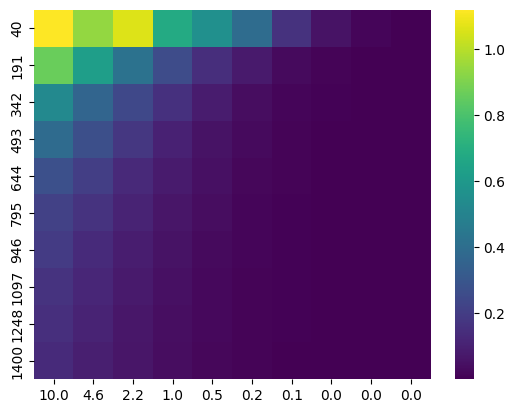

In [145]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ds)